# Tutorial: Complex Layers

In this tutorial, we showcase an iterative SENSE reconstruction on the GPU.

## The data
We provide a 2D+t cardiac CINE datasets. It contains the fully sampled k-space kspace, coil sensitivity maps cmap, and 
sampling masks at acceleration factors R=4 (mask_R4) and R=6 (mask_R6).

In [1]:
import h5py
import merlintf
import os

# Load sample data
# Image sizes (batch, coils, frames, M, N)
# k-space (1, 10, 25, 176, 132)
# mask (1, 1, 25, 1, 132)
# smaps (1, 10, 1, 176, 132)
if not os.path.exists('./cine2dt.h5'):
    os.system('wget https://www.midaslab.org/cine/data/cine2dt.h5')

with h5py.File('cine2dt.h5', 'r') as ds:
    kspace = ds['kspace'][:]
    mask_R4 = ds['mask_R4'][:]
    mask_R6 = ds['mask_R6'][:]
    smaps = ds['smaps'][:]

# reconstruction operators
A = merlintf.keras.layers.MulticoilForwardOp(center=True, coil_axis=-4, channel_dim_defined=False)
AH = merlintf.keras.layers.MulticoilAdjointOp(center=True, coil_axis=-4, channel_dim_defined=False)

# select mask
mask = mask_R4

# apply adjoint
img_us = AH(kspace, mask, smaps)

# iterative sense
optim = merlintf.keras.layers.DCPM(A, AH, weight_init=1e12, max_iter=10)
img_itSENSE = optim([img_us, kspace, mask, smaps]).numpy()

Text(0.5, 1.0, 'Iterative SENSE')

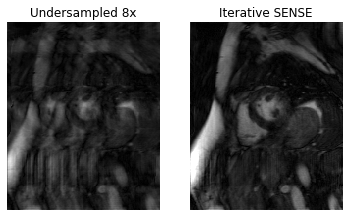

In [2]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure()
plt.subplot(1,2,1)
plt.imshow(np.abs(img_us[0,5]), cmap='gray', vmax=0.00005)
plt.axis('off')
plt.title('Undersampled 8x')
plt.subplot(1,2,2)
plt.imshow(np.abs(img_itSENSE[0,5]), cmap='gray', vmax=0.0001)
plt.axis('off')
plt.title('Iterative SENSE')